# Macroeconomía I

## Programación Dinámica e Iteración de la Función Valor

## (El Modelo Neoclásico de Crecimiento)

Mauricio M. Tejada

ILADES - Universidad Alberto Hurtado

### El Problema de Opmización 

El problema de optimización del planificador central es el siguiente:
\begin{eqnarray*}
\max U_{0} & = & \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+i_{t}=Ak_{t}^{\alpha}\\
 &  & k_{t+1}=i_{t}\\
 &  & k_{0}\,dado.
\end{eqnarray*}

Alternativamente:
\begin{eqnarray*}
\max U_{0} & = & \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+k_{t+1}=Ak_{t}^{\alpha}\\
 &  & k_{0}\,dado.
\end{eqnarray*}

La ecuación de Bellman es:
$$
v(k_{t})=\max_{k_{t+1}}\left\{ \log\left(Ak_{t}^{\alpha}-k_{t+1}\right)+\beta v(k_{t+1})\right\} 
$$

### Solución Algebraica

La solución del problema funcional está dada por la función valor y la función de política:

$$
v(k_{k})\,\,y\,\,k_{t+1}=g(k_{t})
$$

Conocemos la solución de este problema:

\begin{eqnarray*}
k_{t+1} & = & \frac{\beta F}{1+\beta F}Ak_{t}^{\alpha}\\
v(k_{t}) & = & E+F\ln(k_{t})
\end{eqnarray*}
Donde:
\begin{eqnarray*}
E & = & \frac{1}{1-\beta}\left[\ln\left(A\left(1-\alpha\beta\right)\right)+\frac{\alpha\beta}{1-\alpha\beta}\ln\left(Aa\beta\right)\right]\\
F & = & \frac{\alpha}{1-\alpha\beta}
\end{eqnarray*}

La idea es implementar la solución numérica en Julia y compararla con la obtenida algebraicamente.

### Implementación

Algoritmo:

1. Definir un grid de puntos $k$ (discretización) y realizar una conjetura para $v(k)$ en cada posible punto del grid. 
2. Usando la conjetura evaluar el operador $Tv$ para cada punto en el grid (esto implica resolver el $\max$).
3. Evaluar si $v=Tv$ (usando algún grado de tolerancia), en tal caso terminar el proceso. Caso contrario volver al punto 2 usando la función valor resultante.

En términos de la ecuación de Bellman, la iteración sería:
$$
v_{j+1}(k)=\max_{k'}\left\{ \ln\left(Ak^{\alpha}-k'\right)+\beta v_{j}(k')\right\} 
$$

Partir con algún $v_{0}(k)$. 

In [1]:
# Cargamos módulos necesarios

# 1. Graficos
%matplotlib inline 
import matplotlib.pyplot as plt

# 2. Uso de arrays 
import numpy as np

# 3. Optimizadores y herramientas del álgebra lineal
import scipy.optimize as opt
import scipy.linalg as lalg

# 4. Copiar objetos
import copy

In [2]:
# Discretizamos la variable de estado. Definimos primero el número de puntos en el grid de k
n = 500

Parámetros del modelo:

In [3]:
A = 1      # tecnología
α = 0.36   # participación del capital   
β = 0.9    # factor de descuento  

Definimos el grado de tolerancia de la iteración de la función valor:

In [4]:
crit = 1e-6   # valor crítico de convergencia

Definimos el grid de puntos de $k$ como $k_1,...,k_n \in [0.6k^*,1.4k^*]$

In [5]:
# Calcular kss y definir kgrid  
kss   = (α*β)**(1/(1-α))                  # capital en EE    
kgrid = kss * np.linspace(0.6, 1.4, n)   
#print(kgrid)

Note que mientras más puntos tengamos en el grid, más precisión tendremos.

El siguiente paso es iterar la función valor partiendo de la siguiente conjetura:
$$
v_{0}(k)=\left[\begin{array}{c}
0\\
\vdots \\
0
\end{array}\right]
$$

In [6]:
# Definir valores inciales

val0 = np.zeros(n)  # Conjetura Inicial  
valiter = [val0,]  # Vector donde guardamos las iteraciones

Usamos interpolación lineal para evaluar la función entre los puntos definidos en el grid del capital.

In [7]:
v_interpolate = lambda k: np.interp(k, kgrid, val0)
print(v_interpolate(kss))

0.0


Resolvemos usando el método de iteración de la función valor:

In [8]:
diff = 10

while diff > crit:
    Tv = lambda k, kf: np.log(A*k**α-kf) + β*np.interp(kf, kgrid, val0)
    
    val1  = np.zeros(n)  # Vector para guardar la función valor
    kdeci = np.zeros(n)  # Vector para guardar la función de política 

    for i in range(n):
        res = opt.fminbound(lambda x: -Tv(kgrid[i],x), 0.0000001, A*kgrid[i]**α, full_output=1)
        kdeci[i] = res[0]
        val1[i] = -res[1]
    
    diff = np.abs(np.max(val1-val0))      
    #print(diff)
    valiter.append(val1)
    val0 = copy.copy(val1)

### Solución Algebraica

Para este problema particular conocemos la solución alebraica.

In [9]:
# Computar los coeficiente E y F 
E1 = np.log(A*(1 - α*β))
E2 = α*β/(1 - α*β) * np.log(A*α*β)
E = 1/(1 - β)*(E1 + E2)
F = α/(1 - α*β)

# Evaluar en la solucion algebraica la FV y la FP en kgrid
val_cs = E + F * np.log(kgrid)                    # n x 1
kdeci_cs = β*F/(1 + β*F)*A*kgrid**α           # n x 1

### Gráficos

Función de política:

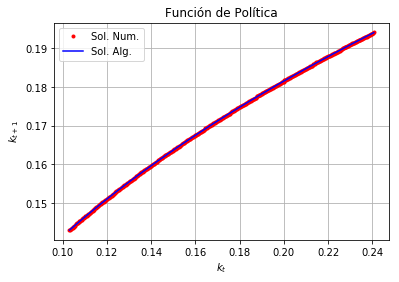

In [10]:
plt.plot(kgrid, kdeci, 'r.', label='Sol. Num.')
plt.plot(kgrid, kdeci_cs, 'b-', label='Sol. Alg.')
plt.title('Función de Política')
plt.xlabel('$k_t$')
plt.ylabel('$k_{t+1}$')
plt.legend()
plt.grid(True)
plt.show()

Función valor:

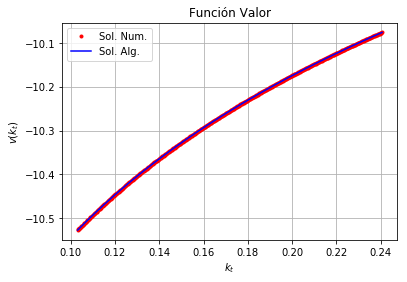

In [11]:
plt.plot(kgrid, val1, 'r.', label='Sol. Num.')
plt.plot(kgrid, val_cs, 'b-', label='Sol. Alg.')
plt.title('Función Valor')
plt.xlabel('$k_t$')
plt.ylabel('$v(k_{t})$')
plt.legend()
plt.grid(True)
plt.show()

Proceso de iteración de la función valor:

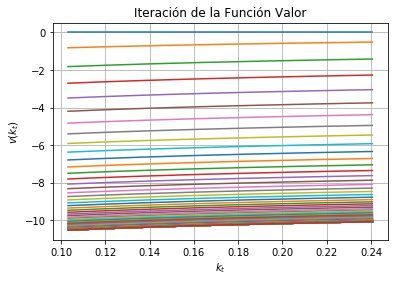

In [12]:
iters = len(valiter)
for i in range(iters):
    plt.plot(kgrid, valiter[i])
plt.title('Iteración de la Función Valor')
plt.xlabel('$k_t$')
plt.ylabel('$v(k_{t})$')
plt.grid(True)
plt.show()    